In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
import data, model, interpretation, utils, vis_utils, glm

In [3]:
test_data = np.load("test_data.npy")
test_label = np.load("test_label.npy")

test_data = np.reshape(test_data, (251, 1, 64, 64, 64))

# Initialize confounder pretrained model

In [4]:
mask = glm.perform_glm()
confounder_mod = model.Confounder3DCNN(mask=mask, in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                    conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

cannot convert 
cannot convert 
cannot convert 
cannot convert 
number of examples:  1334
number of unmatched examples: 0
[70.8 70.8 70.8 82.2 82.2 82.2 82.2 88.6 88.6 88.6 88.6 84.9 70.7 70.7
 70.7 70.7 70.7 70.7 70.7 71.5 71.5 71.5 71.5 74.4 74.4 74.4 74.  74.
 74.5 74.5 74.5 74.5 73.4 64.9 64.9 64.9 64.9 76.6 76.6 76.6 75.8 75.8
 75.8 75.8 75.3 74.9 74.9 74.9 74.9 74.9 83.  83.  83.  83.  80.2 81.3
 81.3 81.3 81.3 81.3 86.3 78.5 78.5 78.5 74.5 74.5 74.5 74.5 72.2 72.2
 70.1 70.1 70.1 70.1 70.1 70.1 70.1 77.  77.  77.  77.  70.6 70.6 70.6
 70.6 70.6 70.6 77.2 77.2 77.2 75.3 75.3 75.3 75.3 70.5 70.5 70.5 70.5
 70.5 71.1 71.1 71.1 87.6 87.6 87.6 87.6 87.6 78.6 78.6 57.1 57.1 57.1
 57.1 78.3 78.3 78.3 78.3 78.3 77.6 77.6 78.3 78.3 78.3 78.3 78.3 62.
 62.  62.  62.  62.  77.1 77.1 77.1 76.9 76.9 76.9 77.3 77.3 71.4 71.4
 71.4 71.4 71.4 70.6 70.6 70.6 70.6 77.3 77.3 77.3 77.3 79.2 79.2 74.8
 74.8 77.4 62.  74.6 74.6 74.6 74.6 71.  78.  82.6 85.1 85.1 85.1 76.7
 76.7 76.7 77.3 77.3 77.3 77

/Users/elissali/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


numbered of errored features:  306
list of errors: i = 
[64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 133, 134, 135, 138, 139, 142, 146, 147, 149, 150, 151, 154, 155, 156, 158, 159, 160, 162, 163, 166, 167, 170, 171, 174, 175, 176, 178, 180, 181, 182, 183, 185, 186, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 209, 210, 211, 212, 213, 215, 219, 220, 222, 223, 226, 227, 229, 231, 232, 235, 236, 238, 241, 243, 247, 250, 252, 259, 263, 268, 270, 271, 275, 279, 280, 281, 283, 284, 285, 286, 291, 293, 295, 296, 298, 299, 300, 301, 302, 307, 312, 314, 315, 316, 317, 323, 327, 330, 331, 333, 335, 341, 342, 343, 344, 346, 347, 350, 351, 357, 358, 360, 361, 362, 363, 367, 370, 374, 375, 379, 382, 385, 386, 389, 390, 391, 393, 394, 395, 400, 401, 402, 403, 4

In [5]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, (64, 64, 64), interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [6]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

# Run loop over dataset

In [7]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

import interpretation
import importlib
importlib.reload(interpretation)

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.sensitivity_analysis(confounder_mod, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct

i:  0
torch.Size([1, 64])
tensor([[-6.2697]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981107680359855
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  1
torch.Size([1, 64])
tensor([[-5.2246]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9946462898515165
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  2
torch.Size([1, 64])
tensor([[-5.6536]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9965074765495956
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  3
torch.Size([1, 64])
tensor([[5.4695]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9958043694496155
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  4
torch.Size([1, 64])
tensor([[6.3006]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9981681108474731
one hot output:  t

(116,)
i:  40
torch.Size([1, 64])
tensor([[-4.2433]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.985842882655561
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  41
torch.Size([1, 64])
tensor([[-3.4229]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9684119001030922
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  42
torch.Size([1, 64])
tensor([[-4.8692]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9923793380148709
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  43
torch.Size([1, 64])
tensor([[-4.1736]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9848361797630787
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  44
torch.Size([1, 64])
tensor([[-6.2598]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9980919655645266
one h

(116,)
i:  80
torch.Size([1, 64])
tensor([[-4.8987]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9925988079048693
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  81
torch.Size([1, 64])
tensor([[-2.4312]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9191735535860062
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  82
torch.Size([1, 64])
tensor([[2.6475]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9338552951812744
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  83
torch.Size([1, 64])
tensor([[0.1214]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.5303128361701965
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  84
torch.Size([1, 64])
tensor([[2.7221]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9383201003074646
one hot

(116,)
i:  120
torch.Size([1, 64])
tensor([[-6.3216]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982061285991222
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  121
torch.Size([1, 64])
tensor([[-6.3117]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.998188346857205
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  122
torch.Size([1, 64])
tensor([[-6.3530]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982614270411432
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  123
torch.Size([1, 64])
tensor([[-6.3214]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982058451278135
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  124
torch.Size([1, 64])
tensor([[-6.3378]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982349061174318


(116,)
i:  160
torch.Size([1, 64])
tensor([[-3.8674]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9795156307518482
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  161
torch.Size([1, 64])
tensor([[-5.8583]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9971520532853901
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  162
torch.Size([1, 64])
tensor([[6.0360]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9976145029067993
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  163
torch.Size([1, 64])
tensor([[6.1070]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9977777600288391
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  164
torch.Size([1, 64])
tensor([[-5.9885]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.997498951619491
on

(116,)
i:  200
torch.Size([1, 64])
tensor([[-5.7452]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9968122523277998
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  201
torch.Size([1, 64])
tensor([[-4.9946]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9932713024318218
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  202
torch.Size([1, 64])
tensor([[-0.3940]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.5972410142421722
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  203
torch.Size([1, 64])
tensor([[-6.3778]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983040587976575
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  204
torch.Size([1, 64])
tensor([[-6.3667]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982851935783401

tensor([[2.3731]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.914749801158905
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  240
torch.Size([1, 64])
tensor([[-5.0308]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9935090006329119
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  241
torch.Size([1, 64])
tensor([[5.6711]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9965676069259644
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  242
torch.Size([1, 64])
tensor([[5.8585]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9971524477005005
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  243
torch.Size([1, 64])
tensor([[-5.7416]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9968007707502693
one hot output:  tensor([[[1.],
      

In [8]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [9]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

57 32 148 14


In [10]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 1.7443401181328926e-09 0.005458625004726601
-0.7620625321536576 1.9976536631661175 1.1921980409861825e-09 0.004634474135921827
-0.7620625321536576 1.9976536631661175 2.7444089667763084e-10 0.001409785548733572
-0.7620625321536576 1.9976536631661175 2.1824550811160225e-09 0.011750303951793316
-0.7620625321536576 1.9976536631661175 1.5458171241026148e-09 0.0046739994524539
-0.7620625321536576 1.9976536631661175 4.3933101138218316e-10 0.0021068407115510364


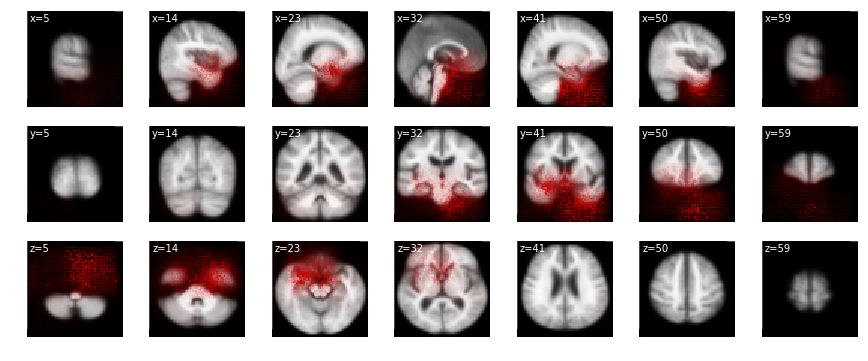

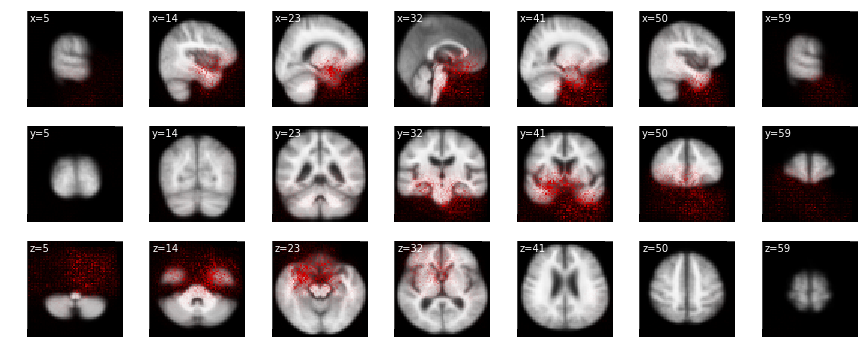

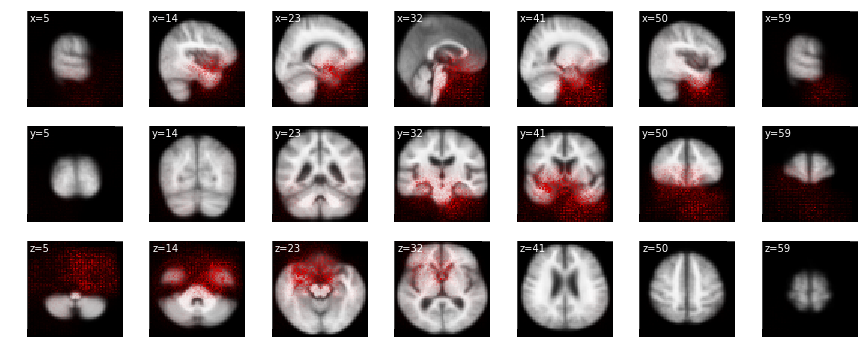

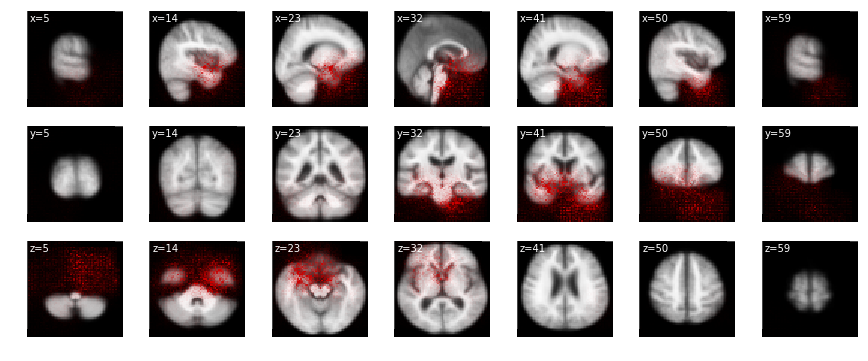

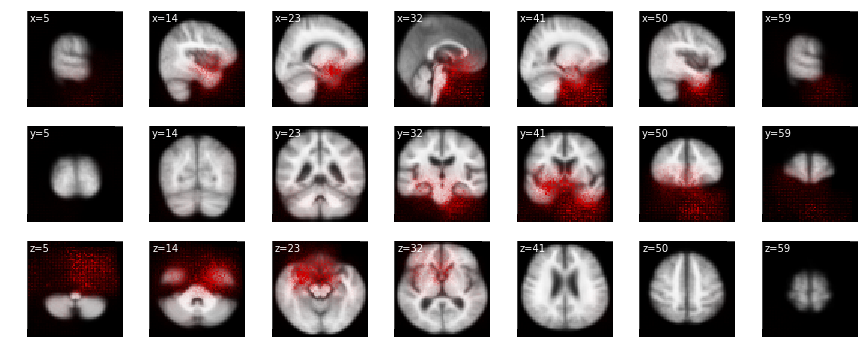

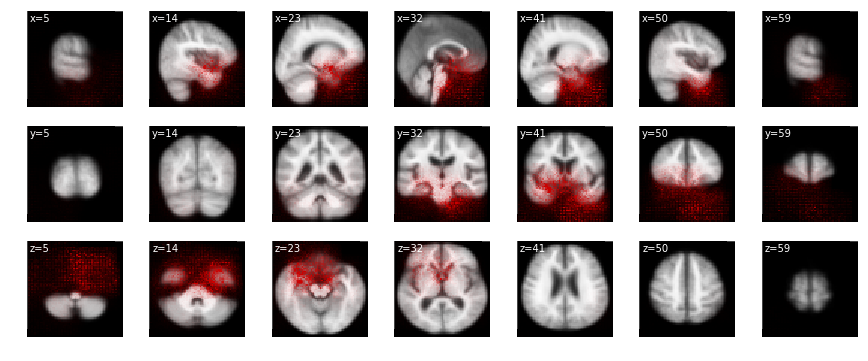

In [11]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)


In [12]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)


{'Temporal_Inf': 4.89392992005215, 'Frontal_Inf_Orb': 3.780115549723092, 'Temporal_Pole_Mid': 3.021518925022182, 'Temporal_Mid': 2.9395225948636345, 'Insula': 2.8256062423876167}
{'Temporal_Inf': 2.1941449072609562, 'Frontal_Inf_Orb': 1.9355642721007063, 'Insula': 1.6995101128092265, 'Temporal_Mid': 1.4474034922143444, 'Putamen': 1.3037854908686}
{'Temporal_Inf': 9.29030289270787, 'Frontal_Inf_Orb': 8.217276973182642, 'Insula': 7.75605690533256, 'Temporal_Mid': 6.841020660903609, 'Frontal_Inf_Tri': 5.94893464238437}
{'Temporal_Inf': 1.0473720542417033, 'Frontal_Inf_Orb': 0.9038180321560559, 'Insula': 0.7612341104994467, 'Temporal_Mid': 0.7129489195223281, 'Temporal_Pole_Sup': 0.6484160887730299}
{'Temporal_Inf': 7.088074827313106, 'Frontal_Inf_Orb': 5.715679821823798, 'Insula': 4.525116355196843, 'Temporal_Mid': 4.386926087077979, 'Temporal_Pole_Mid': 4.1284665319534835}
{'Temporal_Inf': 10.337674946949575, 'Frontal_Inf_Orb': 9.121095005338699, 'Insula': 8.517291015832006, 'Temporal_Mi